In [2]:
import numpy as np 
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def identify(image_path):
    
    frame = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for i, ( x, y, w, h) in enumerate(faces):
        roi_gray = gray[y:y+h, x:x+w] 
        roi_color = frame[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)

        if len(eyes) >= 2:
            return roi_color

In [4]:
path_to_data="./dataset/"
path_to_cr_data="./dataset/cropped/"

In [5]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir() and entry.path != './dataset/cropped':
        img_dirs.append(entry.path)

In [6]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [7]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = identify(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1 

Aishwarya Rai
Generating cropped images in folder:  ./dataset/cropped/Aishwarya Rai
Akshay Kumar
Generating cropped images in folder:  ./dataset/cropped/Akshay Kumar
Jennifer Lawrence
Generating cropped images in folder:  ./dataset/cropped/Jennifer Lawrence
Narendra Modi
Generating cropped images in folder:  ./dataset/cropped/Narendra Modi
Selena Gomez
Generating cropped images in folder:  ./dataset/cropped/Selena Gomez
Shraddha Kapoor
Generating cropped images in folder:  ./dataset/cropped/Shraddha Kapoor
Siddharth Malhotra
Generating cropped images in folder:  ./dataset/cropped/Siddharth Malhotra
Virat Kohli
Generating cropped images in folder:  ./dataset/cropped/Virat Kohli
Will Smith
Generating cropped images in folder:  ./dataset/cropped/Will Smith


In [8]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [9]:
# Cleaning the files which are deleted 
# manually but happens to be in the dictionary.

celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split("/")[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [10]:
class_dict = {}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'Aishwarya Rai': 0,
 'Akshay Kumar': 1,
 'Jennifer Lawrence': 2,
 'Narendra Modi': 3,
 'Selena Gomez': 4,
 'Shraddha Kapoor': 5,
 'Siddharth Malhotra': 6,
 'Virat Kohli': 7,
 'Will Smith': 8}

In [11]:
x, y = [], []
for celebrity_name, training_images in celebrity_file_names_dict.items():
    for training_image in training_images:
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [12]:
len(x[0])

4096

In [13]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(209, 4096)

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0 ) 

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

0.49056603773584906

In [16]:
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.40      0.80      0.53         5
           2       0.40      0.50      0.44         4
           3       1.00      0.80      0.89         5
           4       0.12      0.14      0.13         7
           5       0.36      0.45      0.40        11
           6       1.00      0.40      0.57         5
           7       1.00      0.83      0.91         6
           8       0.00      0.00      0.00         2

    accuracy                           0.49        53
   macro avg       0.56      0.48      0.49        53
weighted avg       0.57      0.49      0.50        53



In [17]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [29]:
scores = []
best_estimators = {}
import pandas as pd

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo, 
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.589718,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.474395,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.647782,{'logisticregression__C': 1}
3,Naive Bayes,0.468145,{}


In [30]:
best_estimators['svm'].score(x_test, y_test)

0.5660377358490566

In [31]:
best_estimators['random_forest'].score(x_test, y_test)

0.33962264150943394

In [32]:
best_estimators['logistic_regression'].score(x_test, y_test)

0.5849056603773585

In [34]:
best_estimators['Naive Bayes'].score(x_test, y_test)

0.4716981132075472

In [35]:
best_clf = best_estimators['logistic_regression']

In [36]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, best_clf.predict(x_test))
cm

array([[2, 0, 1, 0, 2, 2, 0, 0, 1],
       [0, 3, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 2, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 2, 4, 0, 0, 0],
       [1, 0, 0, 0, 1, 6, 2, 0, 1],
       [0, 0, 0, 0, 0, 0, 4, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 6, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

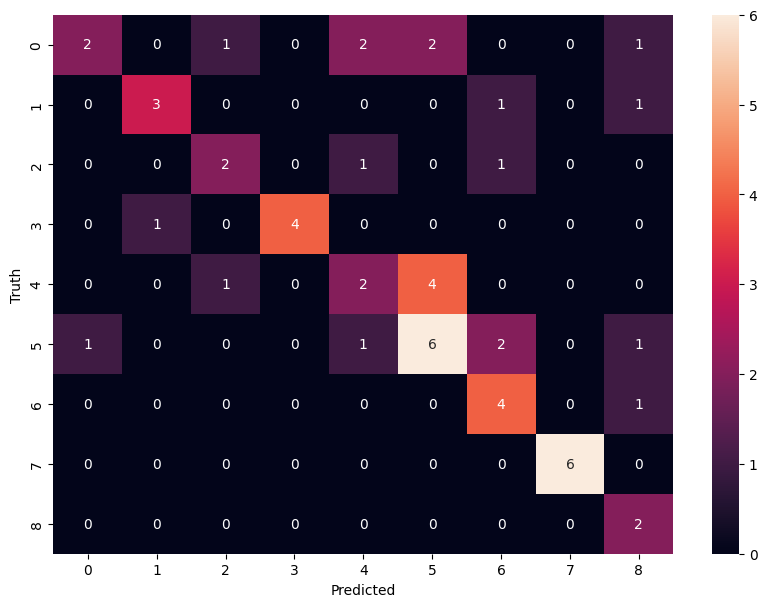

In [37]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
class_dict

{'Aishwarya Rai': 0,
 'Akshay Kumar': 1,
 'Jennifer Lawrence': 2,
 'Narendra Modi': 3,
 'Selena Gomez': 4,
 'Shraddha Kapoor': 5,
 'Siddharth Malhotra': 6,
 'Virat Kohli': 7,
 'Will Smith': 8}

In [39]:
import joblib 

#saving the model as a pickle file
joblib.dump(best_clf, 'final_model.pkl')

['final_model.pkl']

In [ ]:
import json
with open("classd")(json.dumps(class_dict))